In [72]:
from datetime import datetime
import itertools
import json

import importlib
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
import torch

from database import data_utils, data_loader
from models import basic_nn


RUN_FOLDER = "../results/end_to_end/kcm/"
MODEL_NAME = "basic_nn"

In [2]:
# Read in config
with open(RUN_FOLDER+"deeptte_formatted/config.json", "r") as f:
    kcm_config = json.load(f)
# Read in train data
kcm_data_train = []
for i in range(0,5):
    kcm_contents = open(RUN_FOLDER+"deeptte_formatted/train_0"+str(i), "r").read()
    kcm_data_train.append([json.loads(str(item)) for item in kcm_contents.strip().split('\n')])
kcm_data_train = list(itertools.chain.from_iterable(kcm_data_train))
# Read in test data
kcm_contents = open(RUN_FOLDER+"deeptte_formatted/test", "r").read()
kcm_data_valid = [json.loads(str(item)) for item in kcm_contents.strip().split('\n')]

In [63]:
# Set hyperparameters
EPOCHS = 100
BATCH_SIZE = 128
LEARN_RATE = 1e-3
HIDDEN_SIZE = 512

# Reload changes
importlib.reload(basic_nn)
importlib.reload(data_loader)

# Use acceleration if available
device = torch.device("cpu")

# Make data loaders
dataloader_train = data_loader.make_dataloader(kcm_data_train, kcm_config, BATCH_SIZE, device)
dataloader_valid = data_loader.make_dataloader(kcm_data_valid, kcm_config, BATCH_SIZE, device)

# Initialize model
# KCM: 1147
# NWY: 646
embed_dict = {
    'timeID': {
        'vocab_size': 1440,
        'embed_dims': 8,
        'col': 7
    },
    'weekID': {
        'vocab_size': 7,
        'embed_dims': 4,
        'col': 8
    }
}
model = basic_nn.BasicNeuralNet(dataloader_train.dataset[0][0].shape[0], embed_dict, HIDDEN_SIZE).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARN_RATE)
loss_fn = torch.nn.MSELoss()

print(f"Using device: {device}")
print(f"Model: {model}")

Using device: cpu
Model: BasicNeuralNet(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (embeddingTimeID): Embedding(1440, 8)
  (embeddingWeekID): Embedding(7, 4)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=19, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=1, bias=True)
  )
)


In [64]:
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
epoch_number = 0
best_vloss = 100000000.

training_loss = []
validation_loss = []
training_steps = len(dataloader_train)
validation_steps = len(dataloader_valid)

for epoch in range(EPOCHS):
    print(f'EPOCH: {epoch_number}')

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    running_tloss = 0.0
    last_loss = 0.0

    # Iterate over all batches per-epoch
    for i, data in enumerate(dataloader_train):
        # Every data instance is an input + label pair
        inputs, labels = data

        # Run forward/backward
        optimizer.zero_grad()
        preds = model(inputs)
        loss = loss_fn(preds, labels)
        loss.backward()

        # Adjust weights
        optimizer.step()

        # Gather data and report
        running_tloss += loss.item()

    # We don't need gradients on to do reporting
    model.train(False)

    avg_batch_loss = running_tloss / training_steps
    training_loss.append(avg_batch_loss)

    running_vloss = 0.0
    for i, vdata in enumerate(dataloader_valid):
        vinputs, vlabels = vdata
        vpreds = model(vinputs)
        vloss = loss_fn(vpreds, vlabels)
        running_vloss += vloss
    avg_valid_loss = running_vloss / validation_steps
    validation_loss.append(avg_valid_loss.item())

    print(f"LOSS: train {avg_batch_loss} valid {avg_valid_loss}")

    # Track best performance, and save the model's state
    if avg_valid_loss < best_vloss:
        best_vloss = avg_valid_loss
        model_path = f"../results/basic_nn/model_{timestamp}_{epoch_number}"
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

EPOCH: 0
LOSS: train 1.1614491196124108 valid 0.5995565056800842
EPOCH: 1
LOSS: train 0.5397388146364646 valid 0.5945674180984497
EPOCH: 2
LOSS: train 0.5193858924475345 valid 0.5567948222160339
EPOCH: 3
LOSS: train 0.5077101738898309 valid 0.5481318831443787
EPOCH: 4
LOSS: train 0.49488028474561463 valid 0.6097382307052612
EPOCH: 5
LOSS: train 0.48451560964951146 valid 0.5178408026695251
EPOCH: 6
LOSS: train 0.4749313160340428 valid 0.5367994904518127
EPOCH: 7
LOSS: train 0.47142094662992945 valid 0.5282316207885742
EPOCH: 8
LOSS: train 0.45559655189950826 valid 0.5089957118034363
EPOCH: 9
LOSS: train 0.44327783792010156 valid 0.5033998489379883
EPOCH: 10
LOSS: train 0.4349824329599356 valid 0.511465311050415
EPOCH: 11
LOSS: train 0.42724679508707025 valid 0.5104807615280151
EPOCH: 12
LOSS: train 0.422894530407675 valid 0.5059912800788879
EPOCH: 13
LOSS: train 0.41011262504936574 valid 0.47892671823501587
EPOCH: 14
LOSS: train 0.40041647169179534 valid 0.49466657638549805
EPOCH: 15
LO

In [73]:
# Save the model
torch.save(model.state_dict(), RUN_FOLDER+"models/"+MODEL_NAME+".pt")

<AxesSubplot: xlabel='Epoch', ylabel='value'>

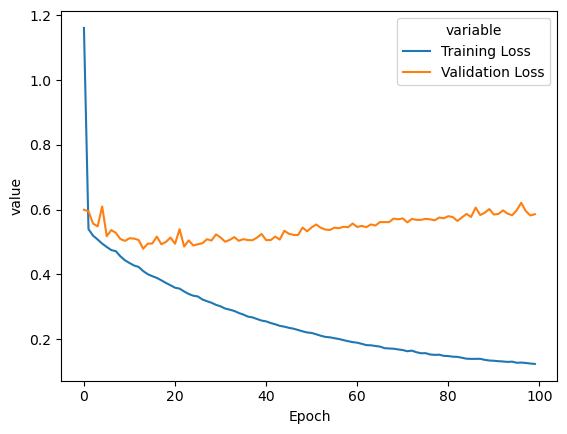

In [74]:
# Plot training curves
plot_data = pd.DataFrame(
    {
        "Epoch": [x for x in range(0,len(training_loss))],
        "Training Loss": training_loss,
        "Validation Loss": validation_loss
    }
)
sns.lineplot(x='Epoch', y='value', hue='variable', data=pd.melt(plot_data, ['Epoch']))

In [75]:
# Look at predictions
labels = []
preds = []
for i, vdata in enumerate(dataloader_valid):
    vinputs, vlabels = vdata
    vpreds = model(vinputs)
    labels.append(vlabels)
    preds.append(vpreds)

# Undo transforms
labels = torch.concat(labels).view(-1).detach().numpy()
preds = torch.concat(preds).view(-1).detach().numpy()
labels = data_utils.de_normalize(labels, kcm_config['time_mean'], kcm_config['time_std'])
preds = data_utils.de_normalize(preds, kcm_config['time_mean'], kcm_config['time_std'])

print(f"MAPE: {metrics.mean_absolute_percentage_error(labels, preds)}")
print(f"RMSE: {np.sqrt(metrics.mean_squared_error(labels, preds))}")
print(f"MAE: {metrics.mean_absolute_error(labels, preds)}")

MAPE: 0.08425559103488922
RMSE: 897.3496704101562
MAE: 614.5342407226562


In [ ]:
# Schedule time
# MAPE: 0.08232331275939941
# RMSE: 841.8658447265625
# MAE: 590.5704956054688

# Schedule time, Speed, 100 E
# MAPE: 0.08425559103488922
# RMSE: 897.3496704101562
# MAE: 614.5342407226562
# Overfitting past ~17 E

# m_state_dict = torch.load('mymodule.pt')
# new_m = MyModule()
# new_m.load_state_dict(m_state_dict)